**Tugas Individu Coding 2 - Fazari Razka Davira**

In [ ]:
!pip install -q split-folders timm grad-cam

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import timm
import cv2
import numpy as np
import shutil
import glob
import splitfolders
import matplotlib.pyplot as plt
from PIL import Image
import copy
import time
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import random
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Menggunakan device: cuda


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive'

path_zip_kaggle = f'{base_path}/busi-kaggle.zip'
target_kaggle   = 'dataset_kaggle'

path_zip_mendeley = f'{base_path}/busi-mendeley.zip'
target_mendeley   = 'dataset_mendeley'

print("=== MEMPROSES DATASET KAGGLE ===")
if os.path.exists(path_zip_kaggle):
    print(f"File Kaggle ditemukan: {path_zip_kaggle}")
    print("Sedang mengekstrak Kaggle...")
    !unzip -q "{path_zip_kaggle}" -d "{target_kaggle}"
    print(f"Sukses! File Kaggle tersimpan di folder: {target_kaggle}\n")
else:
    print(f"ERROR: File Kaggle tidak ditemukan di {path_zip_kaggle}")
    print("Tips: Pastikan nama file zip Kaggle di Drive sesuai dengan variabel 'path_zip_kaggle'.\n")

print("=== MEMPROSES DATASET MENDELEY ===")
if os.path.exists(path_zip_mendeley):
    print(f"File Mendeley ditemukan: {path_zip_mendeley}")
    print("Sedang mengekstrak Mendeley...")
    !unzip -q "{path_zip_mendeley}" -d "{target_mendeley}"
    print(f"Sukses! File Mendeley tersimpan di folder: {target_mendeley}")
else:
    print(f"ERROR: File Mendeley tidak ditemukan di {path_zip_mendeley}")

=== MEMPROSES DATASET KAGGLE ===
File Kaggle ditemukan: /content/drive/MyDrive/busi-kaggle.zip
Sedang mengekstrak Kaggle...
Sukses! File Kaggle tersimpan di folder: dataset_kaggle

=== MEMPROSES DATASET MENDELEY ===
File Mendeley ditemukan: /content/drive/MyDrive/busi-mendeley.zip
Sedang mengekstrak Mendeley...
Sukses! File Mendeley tersimpan di folder: dataset_mendeley


In [ ]:
path_kaggle = "dataset_kaggle/Dataset_BUSI_with_GT"
path_mendeley_root = "dataset_mendeley"

output_path = "dataset_gabungan"

if not os.path.exists(output_path):
    os.makedirs(output_path)

classes = ['benign', 'malignant', 'normal']
for c in classes:
    os.makedirs(os.path.join(output_path, c), exist_ok=True)

def smart_merge_mendeley(root_folder, output_root):
    count_benign = 0
    count_malig = 0

    all_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg', '*.bmp']:
        all_files.extend(glob.glob(os.path.join(root_folder, '**', ext), recursive=True))

    for f in all_files:
        filename = os.path.basename(f).lower()

        target_class = None
        if 'benign' in filename:
            target_class = 'benign'
            count_benign += 1
        elif 'malignant' in filename:
            target_class = 'malignant'
            count_malig += 1
        else:
            parent_folder = os.path.basename(os.path.dirname(f)).lower()
            if 'benign' in parent_folder:
                target_class = 'benign'
                count_benign += 1
            elif 'malignant' in parent_folder:
                target_class = 'malignant'
                count_malig += 1

        if target_class:
            dest_name = f"mendeley_{filename}"
            dest_path = os.path.join(output_root, target_class, dest_name)
            shutil.copy(f, dest_path)

    return count_benign, count_malig

print("=== MULAI MERGE DATASET ===")

print("Copying Kaggle Data...")
def copy_kaggle_simple(src, cls, dst):
    files = glob.glob(os.path.join(src, cls, '*.*'))
    cnt = 0
    for f in files:
        if 'mask' not in os.path.basename(f):
            shutil.copy(f, os.path.join(dst, cls, f"kaggle_{os.path.basename(f)}"))
            cnt += 1
    return cnt

k_benign = copy_kaggle_simple(path_kaggle, 'benign', output_path)
k_malig = copy_kaggle_simple(path_kaggle, 'malignant', output_path)
k_normal = copy_kaggle_simple(path_kaggle, 'normal', output_path)

print("Copying Mendeley Data...")
m_benign, m_malig = smart_merge_mendeley(path_mendeley_root, output_path)

print("\n" + "="*40)
print(f"HASIL AKHIR PENGGABUNGAN:")
print(f"Benign   : {k_benign} (Kaggle) + {m_benign} (Mendeley) = {k_benign + m_benign}")
print(f"Malignant: {k_malig} (Kaggle) + {m_malig} (Mendeley) = {k_malig + m_malig}")
print(f"Normal   : {k_normal} (Kaggle) + 0 = {k_normal}")
print("="*40)

if os.path.exists("dataset_split"):
    shutil.rmtree("dataset_split")

print("Sedang membagi dataset (Splitting)...")
splitfolders.ratio(output_path, output="dataset_split", seed=42, ratio=(.7, .15, .15), group_prefix=None) # Split Dataset (Train 70%, Val 15%, Test 15%)
print("Selesai! Dataset siap di folder 'dataset_split'")

=== MULAI MERGE DATASET ===
Copying Kaggle Data...
Copying Mendeley Data...

HASIL AKHIR PENGGABUNGAN:
Benign   : 437 (Kaggle) + 100 (Mendeley) = 537
Malignant: 210 (Kaggle) + 150 (Mendeley) = 360
Normal   : 133 (Kaggle) + 0 = 133
Sedang membagi dataset (Splitting)...


Copying files: 1030 files [00:00, 1067.38 files/s]

Selesai! Dataset siap di folder 'dataset_split'


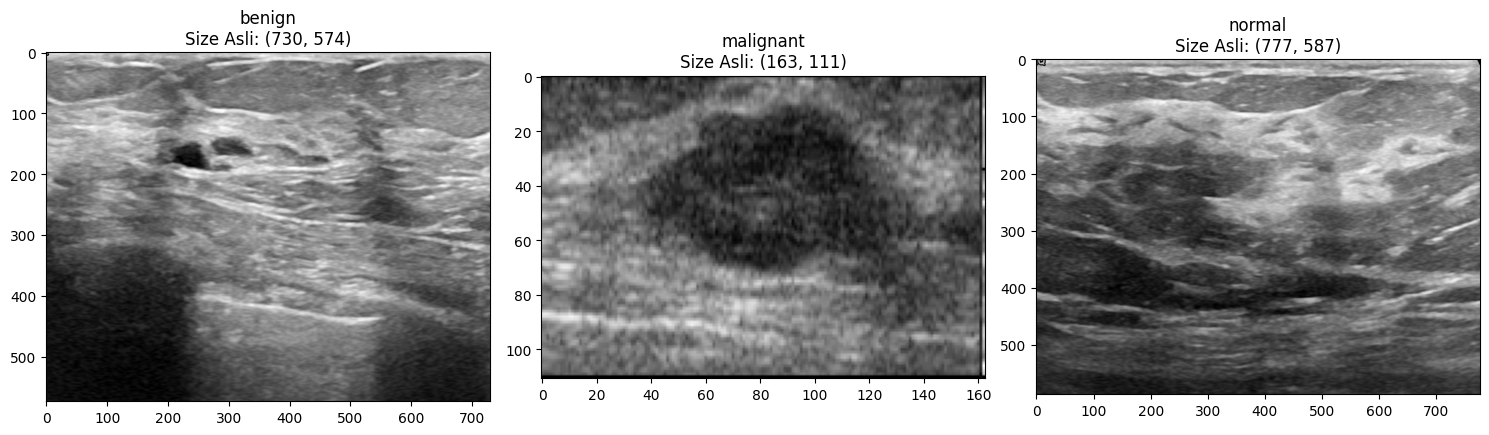

In [ ]:
def show_raw_images(dataset_path, num_images=3):

    classes = ['benign', 'malignant', 'normal']

    plt.figure(figsize=(15, 5))

    for i, cls in enumerate(classes):
        class_folder = os.path.join(dataset_path, 'train', cls)
        random_img = random.choice(os.listdir(class_folder))
        img_path = os.path.join(class_folder, random_img)

        img = Image.open(img_path)

        plt.subplot(1, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{cls}\nSize Asli: {img.size}")
        plt.axis('on')

    plt.tight_layout()
    plt.show()

show_raw_images('dataset_split')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 87.8MB/s]


--- Training DenseNet121 (Raw Data) ---
Ep 1: Val Acc: 0.7451
Ep 2: Val Acc: 0.8235
Ep 3: Val Acc: 0.8235
Ep 4: Val Acc: 0.8235
Ep 5: Val Acc: 0.8889
Ep 6: Val Acc: 0.8758
Ep 7: Val Acc: 0.8693
Ep 8: Val Acc: 0.8431
Ep 9: Val Acc: 0.8301
Ep 10: Val Acc: 0.8497


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
--- Training Xception (Raw Data) ---
Ep 1: Val Acc: 0.6797
Ep 2: Val Acc: 0.7712
Ep 3: Val Acc: 0.8497
Ep 4: Val Acc: 0.8170
Ep 5: Val Acc: 0.8562
Ep 6: Val Acc: 0.8431
Ep 7: Val Acc: 0.8431
Ep 8: Val Acc: 0.8431
Ep 9: Val Acc: 0.8497
Ep 10: Val Acc: 0.8497


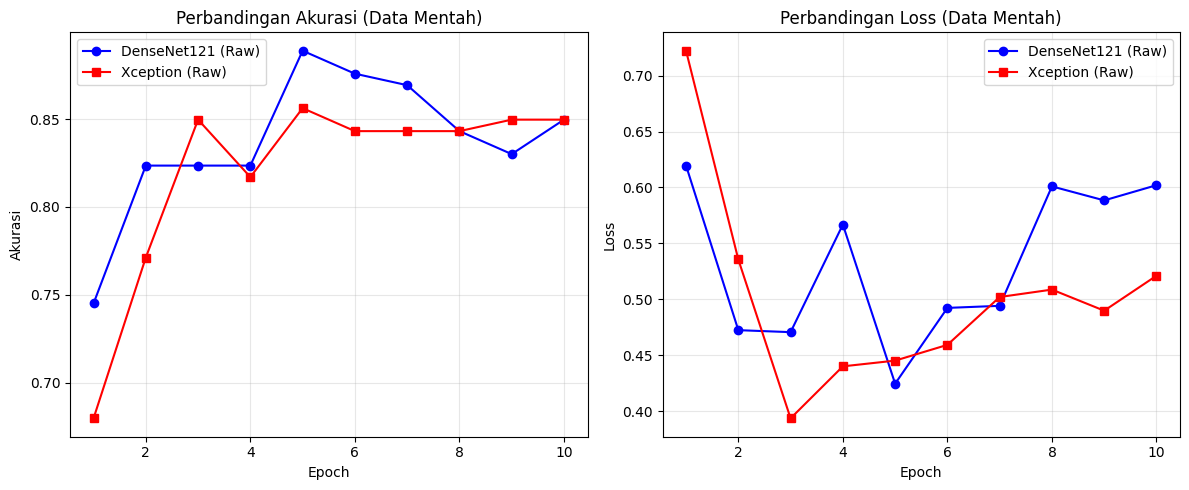

In [ ]:
transform_raw = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'dataset_split'
BATCH = 32

train_set_raw = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_raw)
val_set_raw   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_raw)
test_set_raw  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_raw)

loader_raw = {
    'train': DataLoader(train_set_raw, batch_size=BATCH, shuffle=True),
    'val': DataLoader(val_set_raw, batch_size=BATCH, shuffle=False),
    'test': DataLoader(test_set_raw, batch_size=1, shuffle=False)
}

def train_quick(model, name, epochs=10):
    print(f"--- Training {name} (Raw Data) ---")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    history = {'acc': [], 'loss': []}

    for epoch in range(epochs):
        model.train()
        for inputs, labels in loader_raw['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in loader_raw['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        epoch_loss = val_loss / len(val_set_raw)
        epoch_acc = val_corrects.double() / len(val_set_raw)

        history['acc'].append(epoch_acc.item())
        history['loss'].append(epoch_loss)
        print(f"Ep {epoch+1}: Val Acc: {epoch_acc:.4f}")

    return model, history

# A. DenseNet121
dense_base = models.densenet121(weights='DEFAULT')
dense_base.classifier = nn.Linear(1024, 3)
model_dense_raw, hist_dense_raw = train_quick(dense_base, "DenseNet121")

# B. Xception
xcp_base = timm.create_model('xception', pretrained=True)
xcp_base.fc = nn.Linear(2048, 3)
model_xcp_raw, hist_xcp_raw = train_quick(xcp_base, "Xception")

epochs = range(1, 11)
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, hist_dense_raw['acc'], 'b-o', label='DenseNet121 (Raw)')
plt.plot(epochs, hist_xcp_raw['acc'], 'r-s', label='Xception (Raw)')
plt.title('Perbandingan Akurasi (Data Mentah)')
plt.xlabel('Epoch'); plt.ylabel('Akurasi')
plt.legend(); plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, hist_dense_raw['loss'], 'b-o', label='DenseNet121 (Raw)')
plt.plot(epochs, hist_xcp_raw['loss'], 'r-s', label='Xception (Raw)')
plt.title('Perbandingan Loss (Data Mentah)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

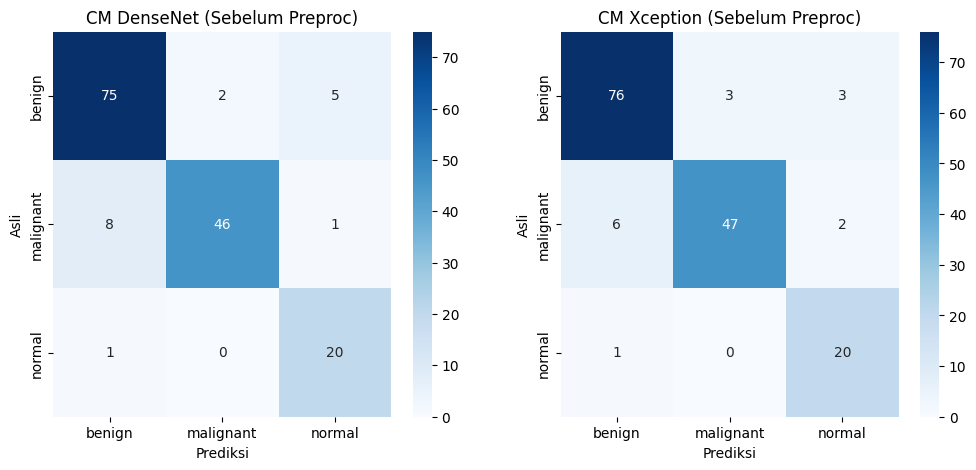

In [ ]:
def show_cm(model, title, ax):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader_raw['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=train_set_raw.classes, yticklabels=train_set_raw.classes)
    ax.set_title(title); ax.set_ylabel('Asli'); ax.set_xlabel('Prediksi')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
show_cm(model_dense_raw, "CM DenseNet (Sebelum Preproc)", axes[0])
show_cm(model_xcp_raw, "CM Xception (Sebelum Preproc)", axes[1])
plt.show()

In [ ]:
class UltrasoundEnhancement(object):
    def __init__(self, apply_clahe=True, apply_denoise=True):
        self.apply_clahe = apply_clahe
        self.apply_denoise = apply_denoise

    def __call__(self, img):
        img_np = np.array(img.convert('L'))

        if self.apply_denoise:
            img_np = cv2.medianBlur(img_np, 5)

        if self.apply_clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img_np = clahe.apply(img_np)

        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)

        return Image.fromarray(img_rgb)

print("Class UltrasoundEnhancement berhasil dibuat!")

Class UltrasoundEnhancement berhasil dibuat!


In [ ]:
transform_dense_train = transforms.Compose([
    UltrasoundEnhancement(apply_clahe=True, apply_denoise=True),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_dense_val = transforms.Compose([
    UltrasoundEnhancement(apply_clahe=True, apply_denoise=True),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_xcp_train = transforms.Compose([
    UltrasoundEnhancement(apply_clahe=True, apply_denoise=True),
    transforms.Resize((320, 320)),
    transforms.CenterCrop(299),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_xcp_val = transforms.Compose([
    UltrasoundEnhancement(apply_clahe=True, apply_denoise=True),
    transforms.Resize((320, 320)),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = 'dataset_split'
batch_size = 32

train_set_dense = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_dense_train)
val_set_dense   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_dense_val)
test_set_dense  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_dense_val)

train_loader_dense = DataLoader(train_set_dense, batch_size=batch_size, shuffle=True)
val_loader_dense   = DataLoader(val_set_dense, batch_size=batch_size, shuffle=False)
test_loader_dense  = DataLoader(test_set_dense, batch_size=1, shuffle=False)

train_set_xcp = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_xcp_train)
val_set_xcp   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_xcp_val)
test_set_xcp  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_xcp_val)

train_loader_xcp = DataLoader(train_set_xcp, batch_size=batch_size, shuffle=True)
val_loader_xcp   = DataLoader(val_set_xcp, batch_size=batch_size, shuffle=False)
test_loader_xcp  = DataLoader(test_set_xcp, batch_size=1, shuffle=False)

loader_d = {
    'train': train_loader_dense,
    'val': val_loader_dense,
    'test': test_loader_dense
}

loader_x = {
    'train': train_loader_xcp,
    'val': val_loader_xcp,
    'test': test_loader_xcp
}

print(f"\nJumlah Kelas     : {len(train_set_dense.classes)} -> {train_set_dense.classes}")
print("-" * 40)
print(f"DenseNet Train   : {len(train_set_dense)} gambar ({len(train_loader_dense)} batches)")
print(f"Xception Train   : {len(train_set_xcp)} gambar ({len(train_loader_xcp)} batches)")
print("-" * 40)


Jumlah Kelas     : 3 -> ['benign', 'malignant', 'normal']
----------------------------------------
DenseNet Train   : 719 gambar (23 batches)
Xception Train   : 719 gambar (23 batches)
----------------------------------------


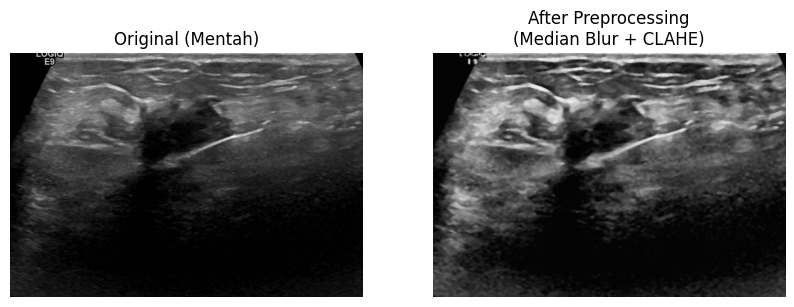

In [ ]:
def show_comparison(dataset_path):
    classes = os.listdir(os.path.join(dataset_path, 'train'))
    sample_class = classes[0]
    sample_folder = os.path.join(dataset_path, 'train', sample_class)
    sample_image_path = os.path.join(sample_folder, os.listdir(sample_folder)[0])

    img_original = Image.open(sample_image_path)

    preprocessor = UltrasoundEnhancement(apply_clahe=True, apply_denoise=True)
    img_processed = preprocessor(img_original)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title("Original (Mentah)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_processed)
    plt.title("After Preprocessing\n(Median Blur + CLAHE)")
    plt.axis('off')

    plt.show()

show_comparison('dataset_split')

In [ ]:
def get_model(model_name, num_classes):
    if model_name == 'densenet':
        model = models.densenet121(weights='DEFAULT')
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif model_name == 'xception':
        model = timm.create_model('xception', pretrained=True)
        in_features = model.get_classifier().in_features
        model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)

def train_model(model, loaders, criterion, optimizer, num_epochs=10, save_name="best.pth"):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print(f"Mulai Training {save_name}...")
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(loaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'val':
                print(f"Epoch {epoch+1}/{num_epochs} - Val Acc: {epoch_acc:.4f}")
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), save_name)

    print(f"Selesai. Best Acc: {best_acc:.4f}")
    return history

In [ ]:
criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 20

print("\n=== TRAIN DENSENET121 ===")
model_dense = get_model('densenet', 3)
opt_dense = optim.Adam(model_dense.parameters(), lr=0.0001)
hist_dense = train_model(model_dense, loader_d, criterion, opt_dense, NUM_EPOCHS, "best_densenet.pth")

print("\n=== TRAIN XCEPTION ===")
model_xcp = get_model('xception', 3)
opt_xcp = optim.Adam(model_xcp.parameters(), lr=0.0001)
hist_xcp = train_model(model_xcp, loader_x, criterion, opt_xcp, NUM_EPOCHS, "best_xception.pth")


=== TRAIN DENSENET121 ===
Mulai Training best_densenet.pth...
Epoch 1/20 - Val Acc: 0.6471
Epoch 2/20 - Val Acc: 0.7255
Epoch 3/20 - Val Acc: 0.7712
Epoch 4/20 - Val Acc: 0.8301
Epoch 5/20 - Val Acc: 0.8170
Epoch 6/20 - Val Acc: 0.8431
Epoch 7/20 - Val Acc: 0.7974
Epoch 8/20 - Val Acc: 0.8301
Epoch 9/20 - Val Acc: 0.8039
Epoch 10/20 - Val Acc: 0.7647
Epoch 11/20 - Val Acc: 0.8366
Epoch 12/20 - Val Acc: 0.8497
Epoch 13/20 - Val Acc: 0.8235
Epoch 14/20 - Val Acc: 0.8366
Epoch 15/20 - Val Acc: 0.8627
Epoch 16/20 - Val Acc: 0.8366
Epoch 17/20 - Val Acc: 0.8366
Epoch 18/20 - Val Acc: 0.8170
Epoch 19/20 - Val Acc: 0.8497
Epoch 20/20 - Val Acc: 0.8366
Selesai. Best Acc: 0.8627

=== TRAIN XCEPTION ===


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Mulai Training best_xception.pth...
Epoch 1/20 - Val Acc: 0.5621
Epoch 2/20 - Val Acc: 0.6013
Epoch 3/20 - Val Acc: 0.7908
Epoch 4/20 - Val Acc: 0.8105
Epoch 5/20 - Val Acc: 0.8170
Epoch 6/20 - Val Acc: 0.8627
Epoch 7/20 - Val Acc: 0.8431
Epoch 8/20 - Val Acc: 0.8235
Epoch 9/20 - Val Acc: 0.8497
Epoch 10/20 - Val Acc: 0.8497
Epoch 11/20 - Val Acc: 0.8497
Epoch 12/20 - Val Acc: 0.8758
Epoch 13/20 - Val Acc: 0.9020
Epoch 14/20 - Val Acc: 0.8889
Epoch 15/20 - Val Acc: 0.8693
Epoch 16/20 - Val Acc: 0.8824
Epoch 17/20 - Val Acc: 0.9085
Epoch 18/20 - Val Acc: 0.8824
Epoch 19/20 - Val Acc: 0.8824
Epoch 20/20 - Val Acc: 0.8497
Selesai. Best Acc: 0.9085



=== PERBANDINGAN 1: AKURASI VALIDASI ===


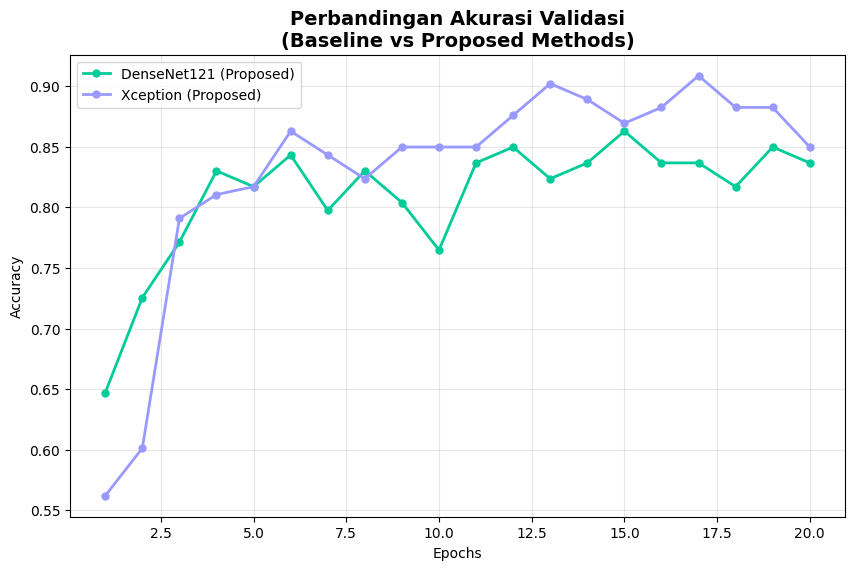


=== PERBANDINGAN 2: VALIDATION LOSS ===


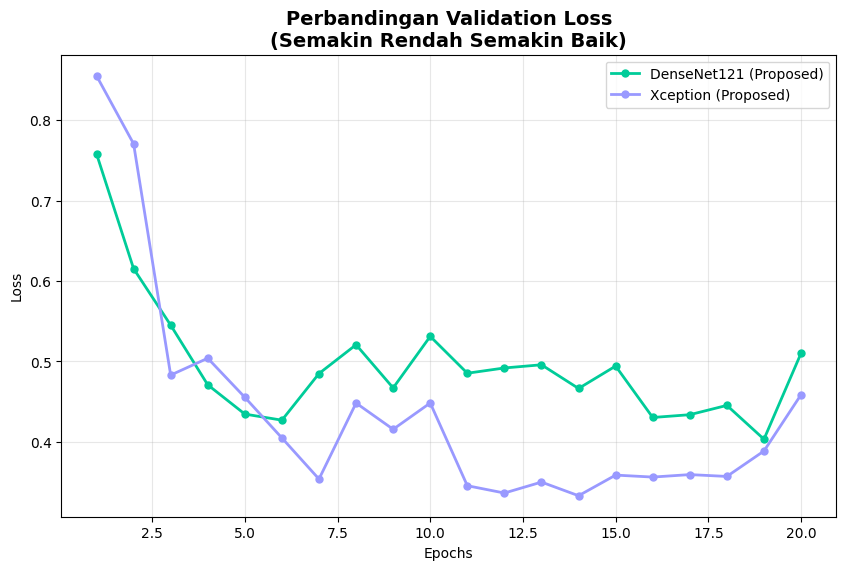

In [ ]:
def plot_comparison(histories, metric, title, ylabel):
    plt.figure(figsize=(10, 6))

    colors = ['#FF9999', '#00CC99', '#9999FF']
    markers = ['--', '-', '-']

    for i, (name, history) in enumerate(histories.items()):
        if history is None:
            print(f"Warning: Data history untuk {name} tidak ditemukan. Skip.")
            continue

        val = history[metric]
        epochs = range(1, len(val) + 1)

        plt.plot(epochs, val, linestyle=markers[i%3], color=colors[i%3],
                 linewidth=2, marker='o', markersize=5, label=name)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()

models_history = {
    'Baseline (No Preproc)': history_base if 'history_base' in locals() else None,
    'DenseNet121 (Proposed)': hist_dense if 'hist_dense' in locals() else None,
    'Xception (Proposed)': hist_xcp if 'hist_xcp' in locals() else None
}

print("\n=== PERBANDINGAN 1: AKURASI VALIDASI ===")
plot_comparison(
    models_history,
    metric='val_acc',
    title='Perbandingan Akurasi Validasi\n(Baseline vs Proposed Methods)',
    ylabel='Accuracy'
)

print("\n=== PERBANDINGAN 2: VALIDATION LOSS ===")
plot_comparison(
    models_history,
    metric='val_loss',
    title='Perbandingan Validation Loss\n(Semakin Rendah Semakin Baik)',
    ylabel='Loss'
)


=== PERBANDINGAN PERFORMA (F1-SCORE) ===
Bobot DenseNet berhasil di-load.
--- Menguji DenseNet121 pada Test Set ---
Laporan Klasifikasi DenseNet121:
              precision    recall  f1-score   support

      benign       0.93      0.94      0.93        82
   malignant       0.93      0.91      0.92        55
      normal       0.90      0.90      0.90        21

    accuracy                           0.92       158
   macro avg       0.92      0.92      0.92       158
weighted avg       0.92      0.92      0.92       158

Weighted F1-Score: 0.9240



/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Bobot Xception berhasil di-load.
--- Menguji Xception pada Test Set ---
Laporan Klasifikasi Xception:
              precision    recall  f1-score   support

      benign       0.84      0.96      0.90        82
   malignant       0.98      0.73      0.83        55
      normal       0.83      0.90      0.86        21

    accuracy                           0.87       158
   macro avg       0.88      0.87      0.86       158
weighted avg       0.89      0.87      0.87       158

Weighted F1-Score: 0.8708

SKOR AKHIR:
1. DenseNet121 : 0.9240
2. Xception    : 0.8708
MODEL TERBAIK: DenseNet121
Menjalankan Grad-CAM pada DenseNet121...

=== HASIL VISUALISASI GRAD-CAM ===


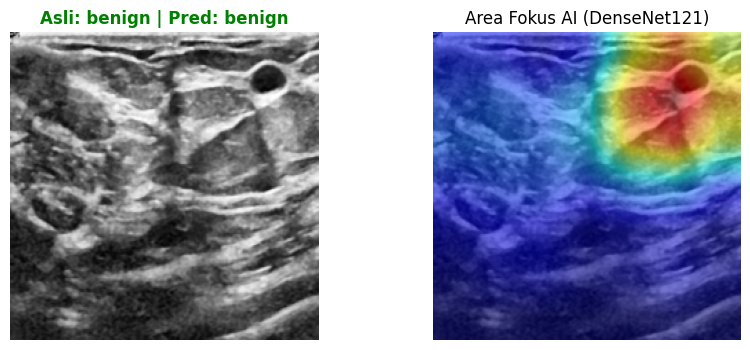

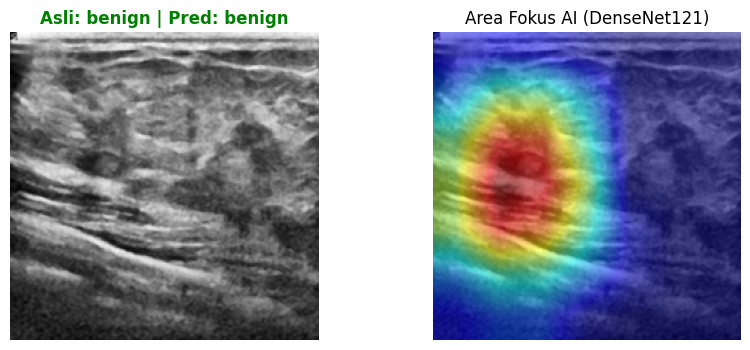

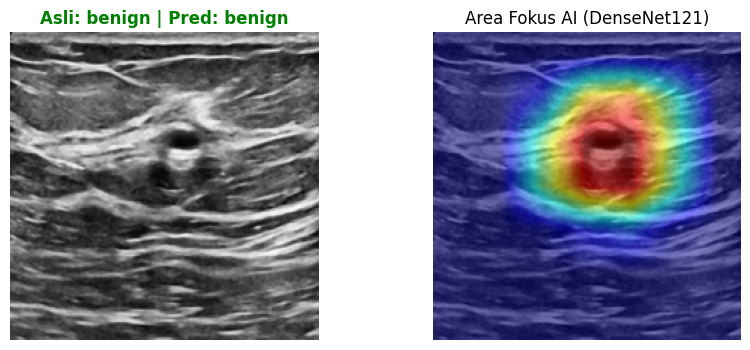

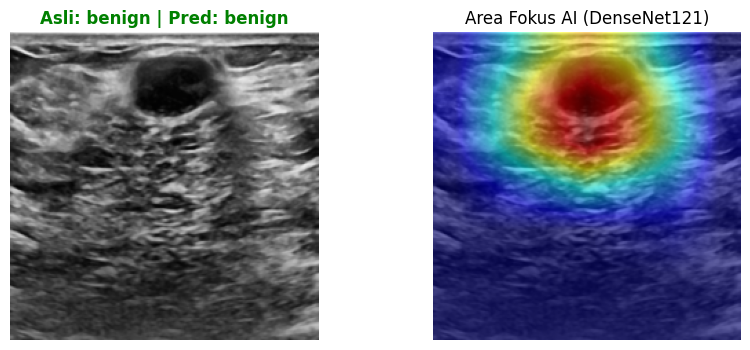

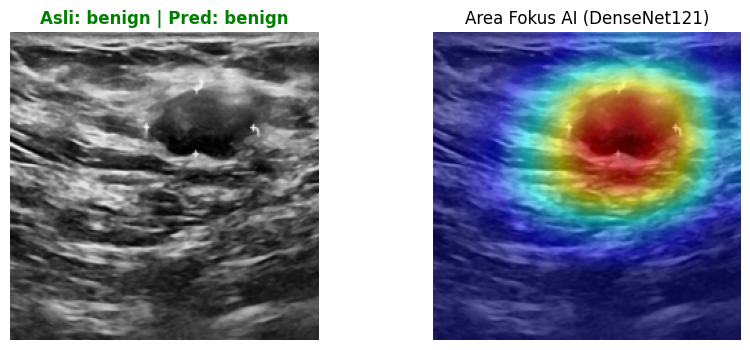

In [ ]:
def evaluate_and_get_f1(model, loader, model_name):
    model.eval()
    y_true = []
    y_pred = []

    print(f"--- Menguji {model_name} pada Test Set ---")

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Laporan Klasifikasi {model_name}:")
    print(classification_report(y_true, y_pred, target_names=train_set_dense.classes))
    print(f"Weighted F1-Score: {f1:.4f}\n")

    return f1, model, loader

print("\n=== PERBANDINGAN PERFORMA (F1-SCORE) ===")

model_dense = get_model('densenet', 3)
try:
    model_dense.load_state_dict(torch.load("best_densenet.pth"))
    print("Bobot DenseNet berhasil di-load.")
except:
    print("File best_densenet.pth belum ada. Pastikan training selesai.")

f1_dense, _, _ = evaluate_and_get_f1(model_dense, loader_d['test'], "DenseNet121")


model_xcp = get_model('xception', 3)
try:
    model_xcp.load_state_dict(torch.load("best_xception.pth"))
    print("Bobot Xception berhasil di-load.")
except:
    print("File best_xception.pth belum ada. Pastikan training selesai.")

f1_xcp, _, _ = evaluate_and_get_f1(model_xcp, loader_x['test'], "Xception")

print("="*40)
print(f"SKOR AKHIR:")
print(f"1. DenseNet121 : {f1_dense:.4f}")
print(f"2. Xception    : {f1_xcp:.4f}")
print("="*40)

if f1_dense >= f1_xcp:
    best_name = "DenseNet121"
    best_model = model_dense
    best_loader = loader_d['test']
    target_layer = [best_model.features[-1]]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
else:
    best_name = "Xception"
    best_model = model_xcp
    best_loader = loader_x['test']
    target_layer = [best_model.act4] if hasattr(best_model, 'act4') else [best_model.conv4]
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

print(f"MODEL TERBAIK: {best_name}")
print(f"Menjalankan Grad-CAM pada {best_name}...")

cam = GradCAM(model=best_model, target_layers=target_layer)

data_iter = iter(best_loader)
max_images = 5
count = 0

print("\n=== HASIL VISUALISASI GRAD-CAM ===")
while count < max_images:
    try:
        images, labels = next(data_iter)
        images = images.to(device)

        input_tensor = images

        outputs = best_model(input_tensor)
        pred_idx = outputs.argmax(dim=1).item()
        targets = [ClassifierOutputTarget(pred_idx)]

        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

        img_np = images[0].cpu().permute(1, 2, 0).numpy()
        img_rgb = (img_np * std) + mean
        img_rgb = np.clip(img_rgb, 0, 1)

        visualization = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        true_label = train_set_dense.classes[labels.item()]
        pred_label_str = train_set_dense.classes[pred_idx]
        color = 'green' if true_label == pred_label_str else 'red'
        plt.title(f"Asli: {true_label} | Pred: {pred_label_str}", color=color, fontweight='bold')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title(f"Area Fokus AI ({best_name})")
        plt.axis('off')

        plt.show()

        count += 1
    except StopIteration:
        break